In [33]:
import numpy as np
import scipy.signal
import scipy.optimize
import matplotlib.pyplot as plt
import sympy as sp

# FUNÇÃO DE TRANSFERÊNCIA

In [34]:
G = scipy.signal.lti([1], [15, 8, 1])

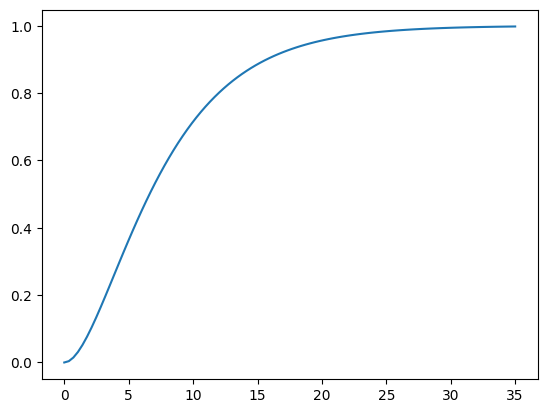

In [35]:
time, response = G.step()
plt.plot(time, response)

# PARÂMETROS DO CONTROLADOR
- **M** define o número de passos de controle no horizonte de controle. Ele representa o período durante o qual o controlador pode ajustar as entradas (ações de controle) para tentar alcançar o setpoint. Esse valor é geralmente menor que o horizonte de predição, pois o controle é aplicado em uma janela mais curta, com o objetivo de minimizar o erro no futuro imediato.

- **P** representa o horizonte de predição, ou seja, quantos passos futuros o controlador tentará prever para ajustar a resposta do sistema. Ele define a "visão de futuro" do controlador, onde ele considera os valores de saída esperados em relação ao setpoint para minimizar os erros. Um horizonte de predição mais longo permite que o controlador tenha uma visão mais ampla do comportamento futuro.

- **dt** é o intervalo de tempo entre cada amostra, definindo o ritmo com que o sistema é atualizado e a frequência com que o controlador ajusta as ações de controle. No contexto de controle preditivo, dt afeta a resolução da previsão e controle, pois determina a granularidade do tempo, em que valores menores de dt permitem previsões mais detalhadas.

In [36]:
M = 10  # Control horizon
P = 20  # Prediction horizon
dt = 0.4  # Sampling rate

setpoint = 6
limits = (-120, 120)
bounds = [limits for i in range(M)]

- **rData** é o sinal de referência, definido como uma função exponencial que converge para o valor setpoint = 6. Esse é o objetivo que o controlador tenta alcançar e simulamos um comportamento ideal

- **tData** é o vetor no tempo discreto tem o tamanho do horizonte de predição

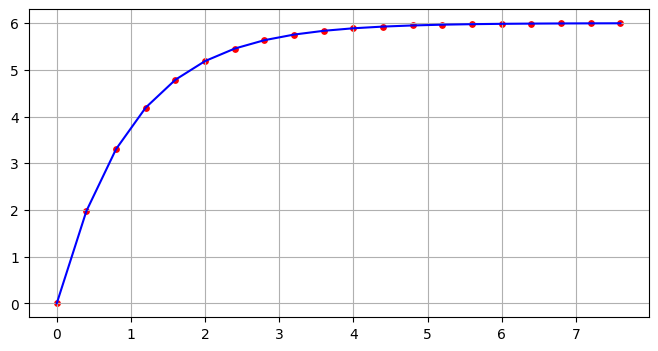

In [37]:
tData = np.arange(0, P*dt, dt)
rData = setpoint*(1 - np.exp(-tData))

plt.figure(figsize=(8, 4))
plt.plot(tData, rData, color='blue')
plt.scatter(tData, rData, s=15, color='red')
plt.grid()

- uData é o vetor de controle que contém os valores de entrada aplicados ao sistema para aproximá-lo do setpoint desejado. Inicialmente, é definido com valores constantes, mas será ajustado pela otimização para minimizar o erro entre a resposta do sistema e o objetivo.

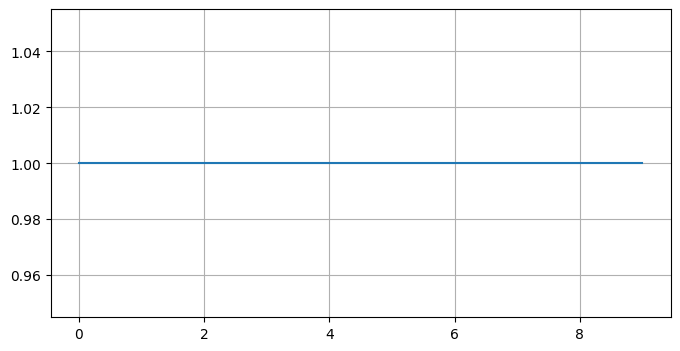

In [38]:
initialValue = 1
uData = initialValue * np.ones(M)

plt.figure(figsize=(8, 4))
plt.plot(uData)
plt.grid()

- Convertendo a função de transferência para espaço de estados, é sempre melhor trabalhar com matrizes quando estamos lidando com controladores mais complexos

In [39]:
matrix = G.to_ss()
A, B, C, D = matrix.A, matrix.B, matrix.C, matrix.D

display(sp.Matrix(A))
display(sp.Matrix(B))
display(sp.Matrix(C))
display(sp.Matrix(D))

Matrix([
[-0.533333333333333, -0.0666666666666667],
[               1.0,                   0]])

Matrix([
[1.0],
[  0]])

Matrix([[0, 0.0666666666666667]])

Matrix([[0]])

In [40]:
print('dimensão da matriz A:', A.shape)
print('ordem do sistema:', A.shape[0])
x0 = np.zeros(A.shape[0])
x0

dimensão da matriz A: (2, 2)
ordem do sistema: 2


array([0., 0.])

- Forçando uma resposta no sistema $G$ com base em um vetor de entrada
- A função extendArray aumentando o tamanho do vetor de entrada $u$ para o tamanho que falta P, repetindo seu último valor

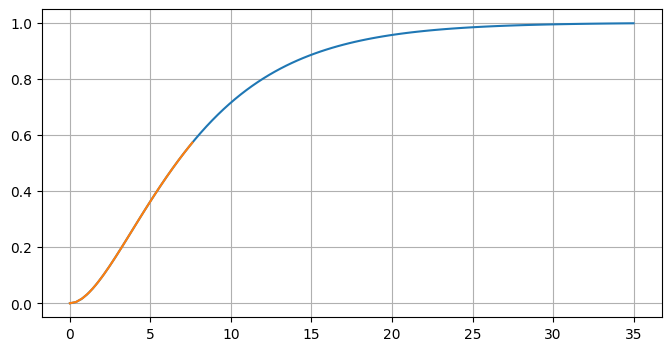

In [41]:
def extendArray(array, newSize):
    n = newSize - len(array)
    newData = np.repeat(array[-1], n)
    return np.concatenate([array, newData])

def forcedResponse(G, U, T, Xo):
    return scipy.signal.lsim(G, U=U, T=T, X0=Xo, interp=False)[1]


U = extendArray(uData, len(tData))
yData = forcedResponse(G, T=tData, U=U, Xo=x0)

plt.figure(figsize=(8, 4))
plt.plot(*G.step())
plt.plot(tData, yData)
plt.grid()

# TREINANDO MODELO
- A função abaixo calcula a soma dos quadrados dos erros para saber a distancia que estamos do objetivo (diferença entre o setpoint e a entrada), ou seja, é o erro com base nos valores de um vetor

In [42]:
def getError(u, T, Xo):
    yData = forcedResponse(G, U=extendArray(u, P), T=T, Xo=Xo)
    return sum((rData - yData)**2)


getError(uData, T=tData, Xo=x0) # erro mt grande

507.6178426551663

- Com a medição do erro medido em objective, usamos scipy.optimize para encontrar a saída que minimiza esse erro, ou seja, qual é a entrada que temos que aplicar para minimizar esse erro

In [43]:
result = scipy.optimize.minimize(getError, uData, args=(tData, x0), bounds=bounds)
result

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 3.103158076069394
        x: [ 1.200e+02  1.200e+02 -5.905e+00 -1.200e+02  5.499e+01
            -3.457e+01  2.506e+01 -6.323e+00  5.138e+00  5.719e+00]
      nit: 119
      jac: [-4.625e-02 -1.253e-02 -4.530e-06  4.982e-04 -3.331e-06
            -1.821e-06  1.688e-06  2.531e-06  3.109e-07 -3.242e-06]
     nfev: 1518
     njev: 138
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>

In [44]:
error = result.fun
error

3.103158076069394

# TESTANDO MODELO

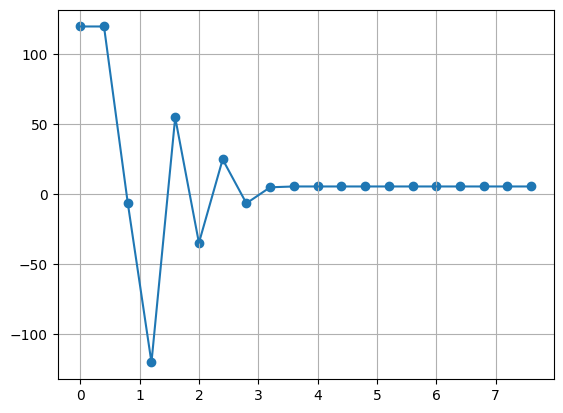

In [45]:
output = result.x
output = extendArray(output, len(tData))

plt.plot(tData, output)
plt.scatter(tData, output)
plt.grid()

In [46]:
len(result.x) == M # próximas 10 ações de conrole

True

Resample the discrete output to continuous time (effectively work out the 0 order hold value)

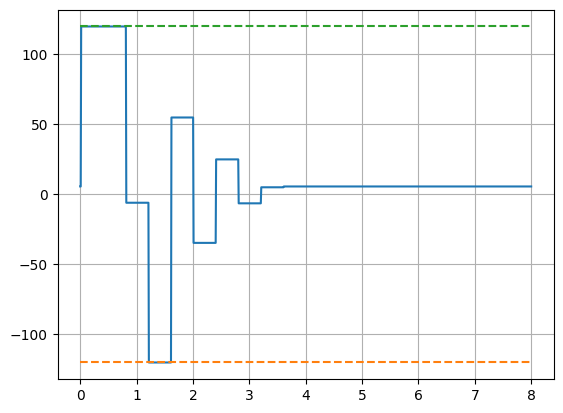

In [47]:
def getContinousArray(time, response, dt):
    indices = (time - 0.01) // dt
    return response[indices.astype(int)]


tData  = np.linspace(0, P*dt, 1000)  
output = getContinousArray(tData, output, dt)

plt.plot(tData, output)
plt.plot(tData, [limits[0] for i in tData], '--')
plt.plot(tData, [limits[1] for i in tData], '--')
plt.grid()

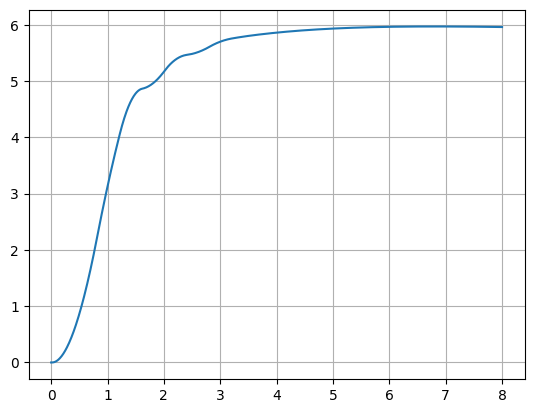

In [48]:
yData = forcedResponse(G, U=output, T=tData, Xo=x0)
plt.plot(tData, yData)
plt.grid()

# CONTROLADOR DIGITAL
- O nosso objetivo é encontrar as próximas $M$ saídas e incluí-las em um loop com tempo de ciclo $dt$ que aplica esse output continuamente, após o final desse ciclo repetimos o processo e encontramos as próximas $M$ saídas

In [52]:
import numpy as np
import scipy.signal
import scipy.optimize
from time import time, sleep

M = 10     
P = 20      
dt = 1     
setpoint = 6 
limits = (-500, 500) 

G = scipy.signal.lti([1], [15, 8, 1]) 
matrix = G.to_ss()
A, B, C, D = matrix.A, matrix.B, matrix.C, matrix.D
x0 = np.zeros(A.shape[0]) 


def getOutputs():
    return

In [ ]:
def setOutput(value):
    return

def applyOutputs(outputs):
    attTime = time()
    i = 0

    while i < len(outputs):
        if time() - attTime < dt:
            continue
        
        attTime = time()
        value   = outputs[i]

        setOutput(value)
        i = i + 1
    

while True:
    outputs = getOutputs()
    
    